## UnSu Unet Object Localization

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import he_uniform
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import numpy as np
import matplotlib.pyplot as plt

2024-10-18 01:12:22.171523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 01:12:22.184282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 01:12:22.187538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 01:12:22.196730: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 01:12:22.887183: W tensorflow/compiler/tf2

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


I0000 00:00:1729239144.462219  255192 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729239144.487187  255192 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729239144.487255  255192 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# Import custom functions to extract our Image arrays and Pixel Mask arrays from our created fits files dataset
from dataGathering import extractImageArray, extractPixelMaskArray, extract_star_catalog, getStarData

# Import astropy to read fits files, and os to interact with the file system
from astropy.io import fits
import os

In [4]:
# getStarData('II/246', 10, 'data')

In [5]:
# Create images and masks arrays lists
images = []
masks = []

# Create df to store the star data inside each fits file
star_data = []

# Create a list of all the fits files in the dataset folder
fits_files = os.listdir('data/')

# For all the fits files in the dataset folder specified in file_path, extract the image and mask arrays to the respective lists
file_path = 'data/'
for file in os.listdir(file_path):
    if file.endswith('.fits'):
        images.append(extractImageArray(file_path + file))
        masks.append(extractPixelMaskArray(file_path + file))
        star_data.append(extract_star_catalog(file_path + file))

        print(file + ' added to dataset')

data7.fits added to dataset
data4.fits added to dataset
data5.fits added to dataset
data8.fits added to dataset
data1.fits added to dataset
data9.fits added to dataset
data6.fits added to dataset
data3.fits added to dataset
data0.fits added to dataset
data2.fits added to dataset


In [6]:
masks[0].shape

(512, 512)

In [7]:
# Encoder path
    #32 kernels
    #3x3 kernel size
    #padding = same considers edges in the input
# Example function to create a U-Net model
def unet_model(input_shape, filters, kernel_size, activation, padding, initializer):
    inputs = layers.Input(input_shape)

    # Encoder path
    c1 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(inputs)
    c1 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p1)
    c2 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p2)
    c3 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p3)
    c4 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(filters[4], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p4)
    c5 = layers.Conv2D(filters[4], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c5)

    # Decoder path
    u6 = layers.Conv2DTranspose(filters[3], (2, 2), strides=(2, 2), padding=padding)(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u6)
    c6 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c6)

    u7 = layers.Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding=padding)(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u7)
    c7 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c7)

    u8 = layers.Conv2DTranspose(filters[1], (2, 2), strides=(2, 2), padding=padding)(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u8)
    c8 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c8)

    u9 = layers.Conv2DTranspose(filters[0], (2, 2), strides=(2, 2), padding=padding)(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u9)
    c9 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [13]:
# Prepare the model for training
#############################################

# Define hyperparameters
hyperparameters = {
    'input_shape': (512, 512, 3),
    'filters': [32, 64, 128, 256, 512],
    'kernel_size': (3, 3),
    'activation': 'relu',
    'padding': 'same',
    'initializer': he_uniform(),
    'optimizer': 'adam',
    'loss': 'binary_crossentropy',
    'metrics': ['accuracy'],
    'epochs': 100,
    'batch_size': 4,
    'validation_split': 0.2,
    'early_stopping_patience': 10
}

# Create and compile the model using hyperparameters
model = unet_model(
    input_shape=hyperparameters['input_shape'],
    filters=hyperparameters['filters'],
    kernel_size=hyperparameters['kernel_size'],
    activation=hyperparameters['activation'],
    padding=hyperparameters['padding'],
    initializer=hyperparameters['initializer']
)
model.compile(
    optimizer=hyperparameters['optimizer'],
    loss=hyperparameters['loss'],
    metrics=hyperparameters['metrics']
)

In [9]:
# Prepare the data for training
#############################################

# Define the test size
image_parameters = {
    'test_size': 0.2,
    'random_state': 0
}


# Convert lists to numpy arrays
# This ensures that the data is in the correct format for train_test_split and model.fit.
train_images = np.array(images)
train_masks = np.array(masks)



# Ensure the input data has the correct shape
if train_images.ndim == 3: # If images are grayscale and have shape (num_samples, height, width)
    train_images = np.expand_dims(train_images, axis=-1) # Add channel dimension
if train_masks.ndim == 3: # If masks are grayscale and have shape (num_samples, height, width)
    train_masks = np.expand_dims(train_masks, axis=-1) # Add channel dimension


# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=image_parameters['test_size'], random_state=image_parameters['random_state'])

# Duplicate channels for the grayscale images since the model expects 3 channels
train_images = np.repeat(train_images, 3, axis=-1)
val_images = np.repeat(val_images, 3, axis=-1)

# Use ImageDataGenerator to load data in batches
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_images, train_masks, batch_size=hyperparameters['batch_size'])
val_generator = val_datagen.flow(val_images, val_masks, batch_size=hyperparameters['batch_size'])

# Show distribution of training and validation sets
print('Training images: ', train_images.shape)
print('Training masks: ', train_masks.shape)
print('Validation images: ', val_images.shape)
print('Validation masks: ', val_masks.shape)

Training images:  (8, 512, 512, 3)
Training masks:  (8, 512, 512, 1)
Validation images:  (2, 512, 512, 3)
Validation masks:  (2, 512, 512, 1)


In [14]:
# Train the model
#############################################

# Implement Early stopping to cut useless epochs
early_stopping = EarlyStopping(
    monitor='val_loss',  # or another metric like 'val_accuracy'
    patience=hyperparameters['early_stopping_patience'],         # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restores the model to the best state after stopping
)


# Train the model
history = model.fit(train_images, train_masks, 
                    validation_data=(val_images, val_masks), 
                    epochs=hyperparameters['epochs'], 
                    batch_size=hyperparameters['batch_size'],
                    callbacks=[early_stopping])

Epoch 1/100


/home/chris/GitHub/AstrID/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_32']. Received: the structure of inputs=*
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 628ms/step - accuracy: 0.3402 - loss: 2014.4701 - val_accuracy: 0.9985 - val_loss: 16.8552
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9945 - loss: 64.3549 - val_accuracy: 0.9985 - val_loss: 23.5162
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9945 - loss: 78.6758 - val_accuracy: 0.9985 - val_loss: 21.8153
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9941 - loss: 75.6786 - val_accuracy: 0.9985 - val_loss: 16.6622
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9951 - loss: 42.5015 - val_accuracy: 0.9985 - val_loss: 13.2360
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9944 - loss: 42.8735 - val_accuracy: 0.9985 - val_loss: 10.9740
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9947 - loss: 32.1976 - val_accuracy: 0.9985 - val_loss: 8.3912
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9945 - loss: 23.8881 - val_accuracy: 0.9516

In [15]:
# Show training loss and validation loss
print('Training loss: ', history.history['loss'][-1])
print('Validation loss: ', history.history['val_loss'][-1])

# Show training accuracy and validation accuracy
print('Training accuracy: ', history.history['accuracy'][-1])
print('Validation accuracy: ', history.history['val_accuracy'][-1])

Training loss:  6.198826789855957
Validation loss:  1.7683912515640259
Training accuracy:  0.9900317192077637
Validation accuracy:  0.9970626831054688


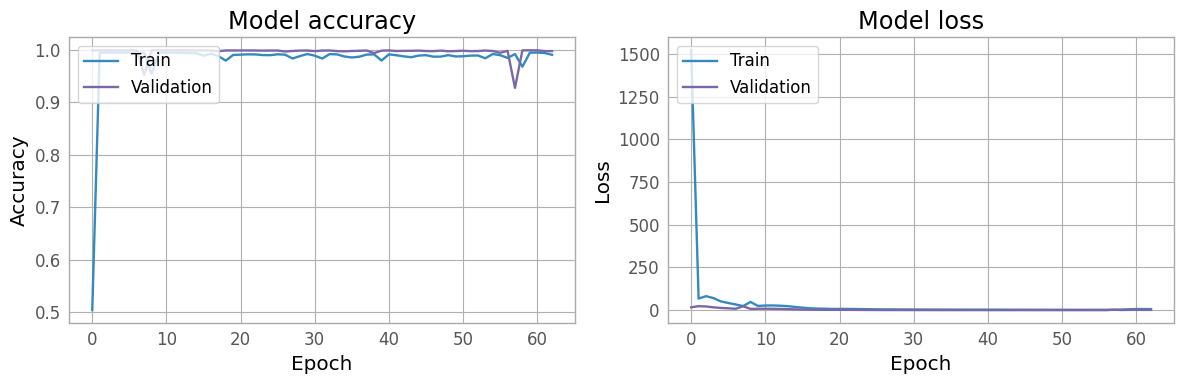

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [17]:
# Save the model
model.save('unet_model.keras')

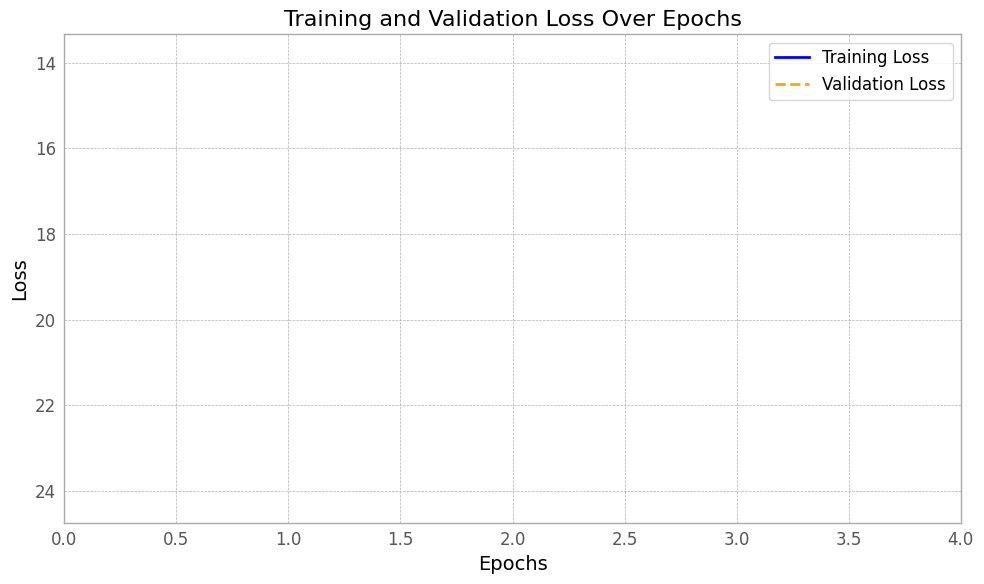

In [40]:



# Set a larger figure size
plt.figure(figsize=(10, 6))

# Plot the training and validation loss
plt.plot(history.history['loss'], color='blue', linestyle='-', linewidth=2, label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', linestyle='--', linewidth=2, label='Validation Loss')

# Add title and labels
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend to differentiate between training and validation loss
plt.legend(loc='best', fontsize=12)

# Set limits for better visualization
plt.xlim(0, len(history.history['loss']) - 1)  # From epoch 0 to the last epoch
plt.ylim(min(history.history['loss']) * 0.95, max(history.history['val_loss']) * 1.05)

# Show the plot
plt.tight_layout()
plt.show()
